## Importing libraries

In [1]:
!pip install xgboost
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.0 MB/s eta 0:00:00


In [2]:
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Real

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## XGBoost implementation

### Preparing the Dataset

In [4]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_1d.csv')

In [5]:
# adding features that make more sense than raw data
all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

for lag in range(1, 4):
  all_prices[f"Gold_lag_{lag}"] = all_prices["Gold"].shift(lag)
  all_prices[f"Silver_lag_{lag}"] = all_prices["Silver"].shift(lag)
  all_prices[f"CAD_lag_{lag}"] = all_prices["CAD"].shift(lag)

In [6]:
# price to predict, the price of the next timestep
all_prices["Gold_target"] = all_prices["Gold"].shift(-1)
all_prices["Silver_target"] = all_prices["Silver"].shift(-1)
all_prices["CAD_target"] = all_prices["CAD"].shift(-1)

In [7]:
all_prices = all_prices.dropna()

In [8]:
all_prices.head()

,Date,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
4,2003-09-24,387.500000,5.302,0.740686,0.004146,0.012798,0.003703,383.800000,5.2678,0.738769,...,0.737953,387.200012,5.265,0.738443,381.799988,5.282,0.742280,385.000000,5.214,0.741015
5,2003-09-25,385.000000,5.214,0.741015,-0.006452,-0.016597,0.000445,385.479999,5.2596,0.740076,...,0.740686,385.899994,5.235,0.737953,387.200012,5.265,0.738443,380.799988,5.137,0.739208
6,2003-09-26,380.799988,5.137,0.739208,-0.010909,-0.014768,-0.002439,385.279999,5.2306,0.739461,...,0.741015,387.500000,5.302,0.740686,385.899994,5.235,0.737953,382.399994,5.070,0.739700
7,2003-09-29,382.399994,5.070,0.739700,0.004202,-0.013043,0.000666,384.319995,5.1916,0.739712,...,0.739208,385.000000,5.214,0.741015,387.500000,5.302,0.740686,385.399994,5.137,0.740631
8,2003-09-30,385.399994,5.137,0.740631,0.007845,0.013215,0.001259,384.219995,5.1720,0.740248,...,0.739700,380.799988,5.137,0.739208,385.000000,5.214,0.741015,384.299988,5.100,0.743439


In [9]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5785 entries, 4 to 5788
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           5785 non-null   object 
 1   Gold           5785 non-null   float64
 2   Silver         5785 non-null   float64
 3   CAD            5785 non-null   float64
 4   Gold_ret       5785 non-null   float64
 5   Silver_ret     5785 non-null   float64
 6   CAD_ret        5785 non-null   float64
 7   Gold_ma        5785 non-null   float64
 8   Silver_ma      5785 non-null   float64
 9   CAD_ma         5785 non-null   float64
 10  Gold_lag_1     5785 non-null   float64
 11  Silver_lag_1   5785 non-null   float64
 12  CAD_lag_1      5785 non-null   float64
 13  Gold_lag_2     5785 non-null   float64
 14  Silver_lag_2   5785 non-null   float64
 15  CAD_lag_2      5785 non-null   float64
 16  Gold_lag_3     5785 non-null   float64
 17  Silver_lag_3   5785 non-null   float64
 18  CAD_lag_3    

In [10]:
all_prices.describe()

,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,Gold_lag_1,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
count,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,...,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000,5785.000000
mean,1366.685669,19.581277,0.837559,0.000468,0.000596,0.000008,1365.403954,19.565706,0.837569,1366.045047,...,0.837563,1365.404649,19.565704,0.837568,1364.763318,19.557923,0.837574,1367.326015,19.589055,0.837554
std,655.601612,8.393301,0.100374,0.010949,0.020147,0.005390,653.728591,8.368483,0.100280,654.748310,...,0.100369,653.892931,8.378072,0.100364,653.037205,8.370427,0.100357,656.453592,8.400910,0.100380
min,369.200012,4.810000,0.679486,-0.093538,-0.177541,-0.035345,372.780005,4.843400,0.689629,369.200012,...,0.679486,369.200012,4.810000,0.679486,369.200012,4.810000,0.679486,369.200012,4.810000,0.679486
25%,937.700012,14.414000,0.753852,-0.004533,-0.008305,-0.002851,935.639990,14.420400,0.754152,937.599976,...,0.753852,937.200012,14.403000,0.753852,937.000000,14.400000,0.753852,939.000000,14.418000,0.753852
50%,1288.800049,17.697001,0.798537,0.000228,0.000294,0.000000,1288.799976,17.698600,0.798271,1288.699951,...,0.798537,1288.599976,17.686001,0.798537,1288.599976,17.684999,0.798537,1288.900024,17.698000,0.798537
75%,1729.599976,24.264000,0.935716,0.006179,0.010519,0.002857,1729.960010,24.245600,0.936736,1729.500000,...,0.935716,1729.300049,24.254999,0.935716,1729.300049,24.250999,0.935716,1730.000000,24.266001,0.935716
max,4336.399902,53.332001,1.088495,0.090277,0.129707,0.037637,4224.420020,51.647800,1.074368,4336.399902,...,1.088495,4336.399902,53.332001,1.088495,4336.399902,53.332001,1.088495,4336.399902,53.332001,1.088495


In [11]:
X = all_prices.drop(columns=["Date", 'Gold_target', 'Silver_target', 'CAD_target'])
y = all_prices[['Gold_target', 'Silver_target', 'CAD_target']]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

### XGBoost experimenting

In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [14]:
num_round = 15
param = {
    'learning_rate': 0.5,
    'max_depth': 30,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-rmse:127.94789	eval-rmse:646.73918


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-rmse:64.81458	eval-rmse:559.41182
[2]	train-rmse:33.35706	eval-rmse:513.99494
[3]	train-rmse:17.89171	eval-rmse:485.89207
[4]	train-rmse:10.11894	eval-rmse:469.72880
[5]	train-rmse:6.02363	eval-rmse:468.46177
[6]	train-rmse:3.75426	eval-rmse:465.29921
[7]	train-rmse:2.41073	eval-rmse:465.81083
[8]	train-rmse:1.57910	eval-rmse:465.67158
[9]	train-rmse:1.06165	eval-rmse:464.79564
[10]	train-rmse:0.72063	eval-rmse:464.56847
[11]	train-rmse:0.49983	eval-rmse:464.26816
[12]	train-rmse:0.35214	eval-rmse:464.05705
[13]	train-rmse:0.24992	eval-rmse:463.90806
[14]	train-rmse:0.17830	eval-rmse:463.80314


In [15]:
y_pred = bst.predict(dtest)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

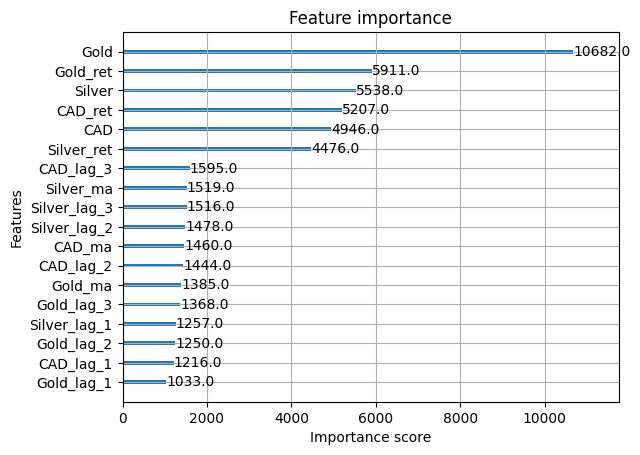

In [16]:
xgb.plot_importance(bst)

In [17]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [18]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [19]:
gold_pred = y_pred[:, 0]
silver_pred = y_pred[:, 1]
cad_pred = y_pred[:, 2]

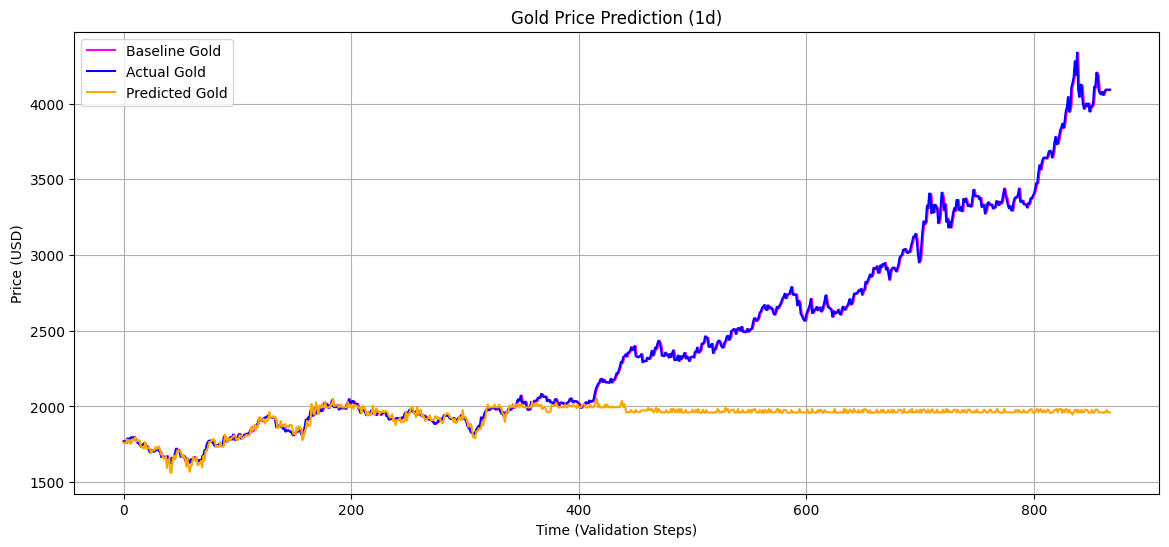

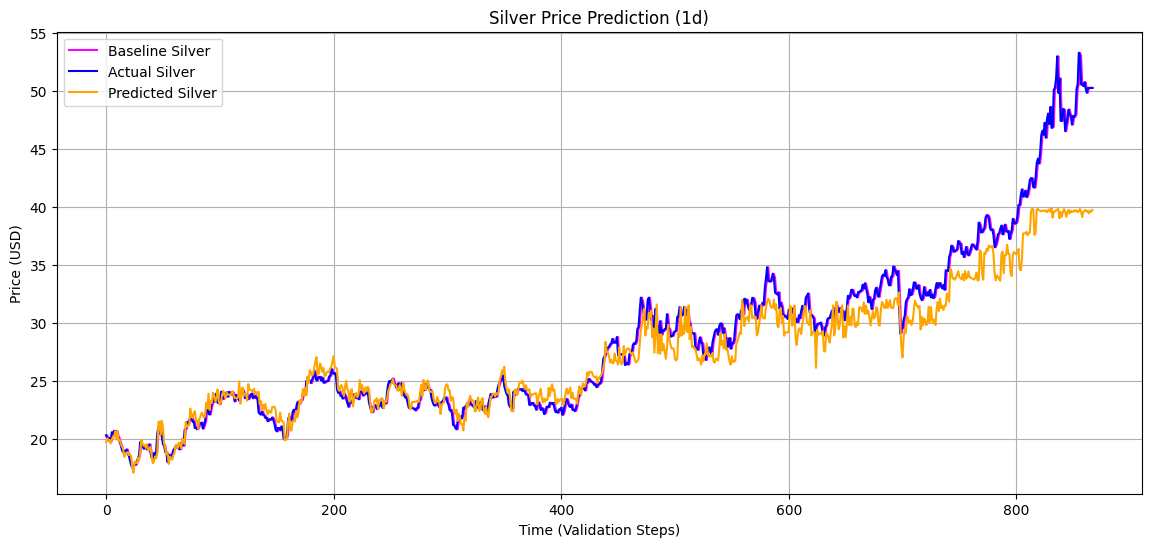

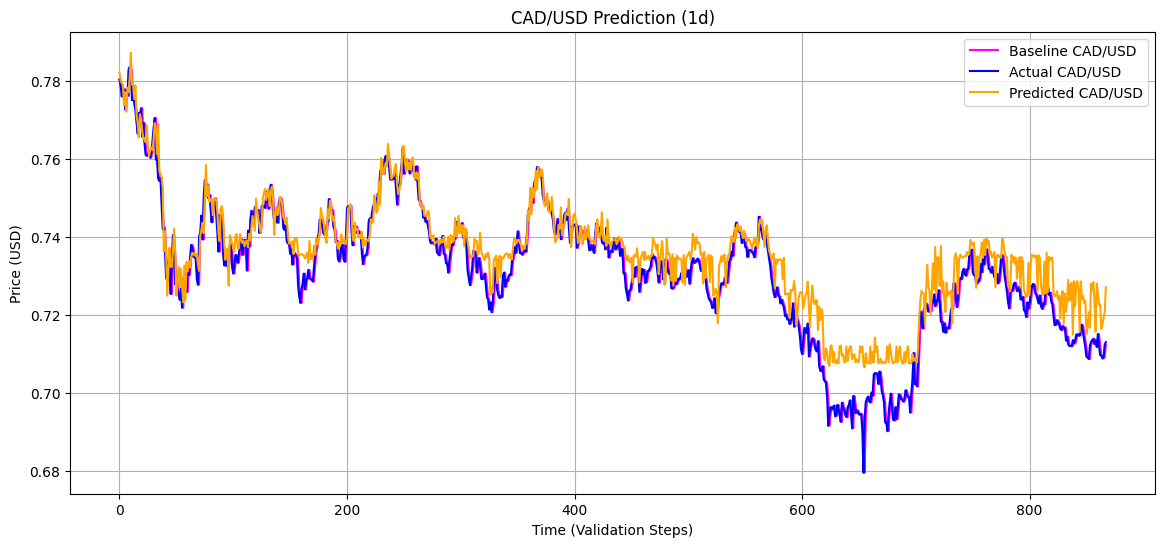

In [20]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (1d)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (1d)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (1d)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Tuning

In [21]:
search_space = {
    'max_depth': Integer(3, 20),
    'learning_rate': Real(0.001, 1, prior='log-uniform'),
    'n_estimators': Integer (5, 30),
    'eval_metric': ['rmse', 'mae', 'mape']
}

In [22]:
n_train = int(len(X_train) * 0.70)
n_val = int(len(X_train) * 0.15)

train_indices = np.full(n_train, -1)
val_indices = np.zeros(n_val)

test_fold = np.concatenate([train_indices, val_indices])
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)

In [23]:
opt = BayesSearchCV(
    XGBRegressor(tree_method="auto", random_state=42),
    search_space,
    n_iter=50,
    cv=ps,
    scoring='neg_mean_absolute_error',
    random_state=42
)

In [24]:
opt.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('rmse'), 1.0, np.int64(3), np.int64(30)] before, using random point ['rmse', 0.007644811133199065, np.int64(5), np.int64(8)]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('rmse'), 1.0, np.int64(3), np.int64(30)] before, using random point ['mape', 0.007765027372650694, np.int64(12), np.int64(14)]
  warnings.warn(


BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,...
                                     n_jobs=None, num_parallel_tree=None, ...),
              random_state=42, scoring='neg_mean_absolute_error',
              search_spaces={'eval_metric': ['rmse', 'mae', 'mape'],
                             'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=5, high=30, prior='uniform', transform='normalize')})

### Metrics Evaluation

In [25]:
best_params = opt.best_params_
best_params

OrderedDict([('eval_metric', 'rmse'),
             ('learning_rate', 0.31469292953112105),
             ('max_depth', 3),
             ('n_estimators', 19)])

In [26]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [27]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [28]:
gold_pred = y_pred[:, 0]
silver_pred = y_pred[:, 1]
cad_pred = y_pred[:, 2]

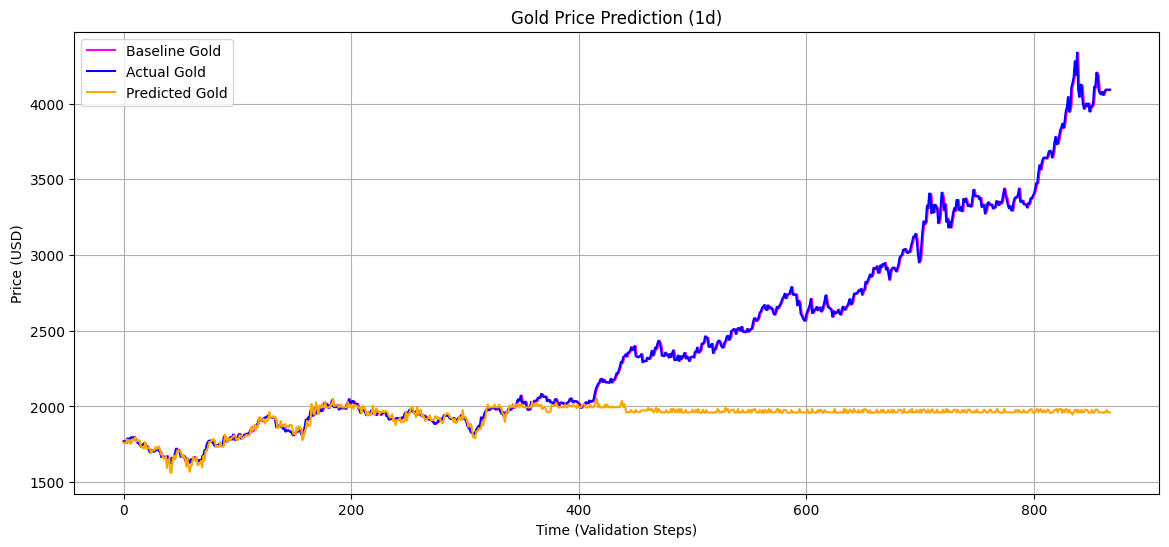

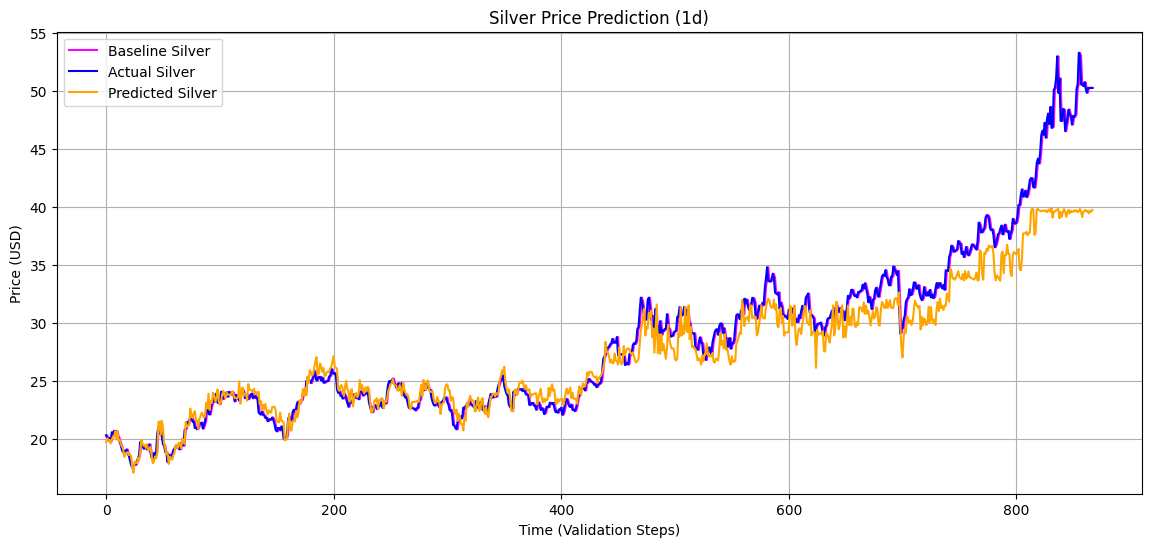

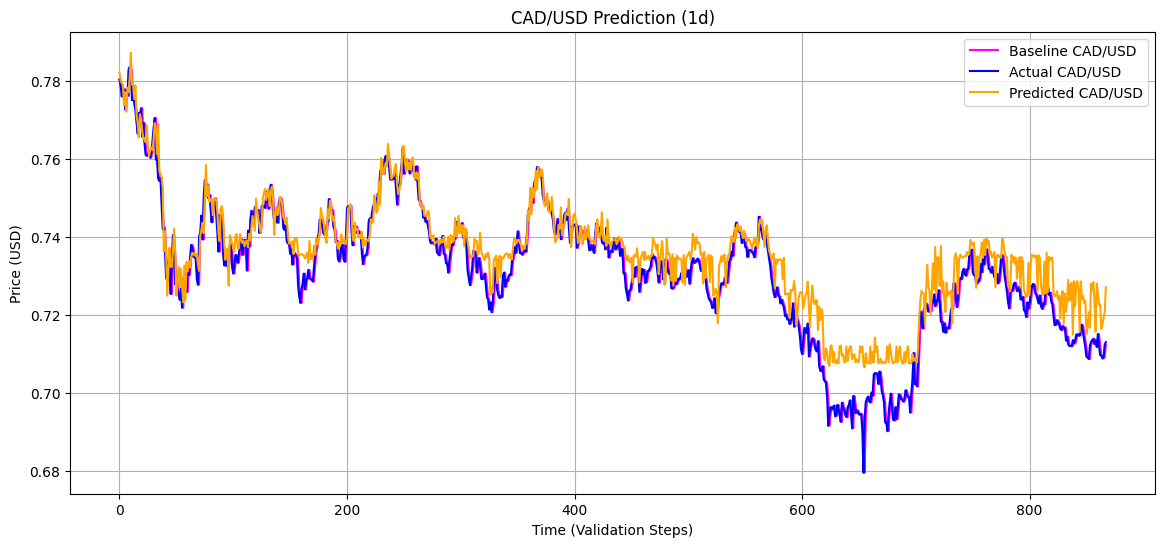

In [29]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (1d)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (1d)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (1d)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Mean Absolute Error :', mae)
print('Root Mean Squared Error :', rmse)
print('Mean Absolute Percentage Error :', mape)

Mean Absolute Error : 168.7803192138672
Root Mean Squared Error : 459.27776181739955
Mean Absolute Percentage Error : 0.06333067268133163


In [31]:
print("MAE:")
print("Gold  :", mean_absolute_error(y_test['Gold_target'], y_pred[:,0]))
print("Silver:", mean_absolute_error(y_test['Silver_target'], y_pred[:,1]))
print("CAD   :", mean_absolute_error(y_test['CAD_target'], y_pred[:,2]))

print("RMSE:")
print("Gold  :", np.sqrt(mean_squared_error(y_test['Gold_target'], y_pred[:,0])))
print("Silver:", np.sqrt(mean_squared_error(y_test['Silver_target'], y_pred[:,1])))
print("CAD   :", np.sqrt(mean_squared_error(y_test['CAD_target'], y_pred[:,2])))

print("MAPE:")
print("Gold  :", mean_absolute_percentage_error(y_test['Gold_target'], y_pred[:,0]))
print("Silver:", mean_absolute_percentage_error(y_test['Silver_target'], y_pred[:,1]))
print("CAD   :", mean_absolute_percentage_error(y_test['CAD_target'], y_pred[:,2]))

MAE:
Gold  : 505.5449701124622
Silver: 0.7930649458538003
CAD   : 0.0029063752856672083
RMSE:
Gold  : 795.4907916061713
Silver: 1.592209329363824
CAD   : 0.003681759572588309
MAPE:
Gold  : 0.16215434107542187
Silver: 0.02385777258950832
CAD   : 0.003979789058339112


In [32]:
best_model.save_model('xgboost_1d.json')
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.31469292953112105, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=19, n_jobs=None,
             num_parallel_tree=None, ...)

# Future Predictions

In [33]:
params = XGBRegressor()
params.load_model('xgboost_1d.json')
params = params.get_xgb_params()
model = XGBRegressor(**params)

# Fit this new model on the entire dataset (X, y)
model.fit(X, y)
model

XGBRegressor(base_score=[1178.746, 18.035183, 0.85625106], booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [34]:
def forecast_interval(model, df, start_date, end_date):

    lag = 3
    window = 5

    historical_raw_data = df[['Gold', 'Silver', 'CAD']].iloc[-window:].copy()

    predictions = []
    future_index = pd.date_range(start=start_date, end=end_date, freq="1d")

    training_columns = X.columns.tolist()

    for _ in future_index:

        current_features_dict = {}

        current_gold = historical_raw_data['Gold'].iloc[-1]
        current_silver = historical_raw_data['Silver'].iloc[-1]
        current_cad = historical_raw_data['CAD'].iloc[-1]

        current_features_dict['Gold'] = current_gold
        current_features_dict['Silver'] = current_silver
        current_features_dict['CAD'] = current_cad

        # Returns (needs current and previous)
        prev_gold = historical_raw_data['Gold'].iloc[-2]
        prev_silver = historical_raw_data['Silver'].iloc[-2]
        prev_cad = historical_raw_data['CAD'].iloc[-2]

        current_features_dict['Gold_ret'] = (current_gold - prev_gold) / prev_gold if prev_gold != 0 else 0
        current_features_dict['Silver_ret'] = (current_silver - prev_silver) / prev_silver if prev_silver != 0 else 0
        current_features_dict['CAD_ret'] = (current_cad - prev_cad) / prev_cad if prev_cad != 0 else 0

        # Moving Averages (needs last 5 values)
        current_features_dict['Gold_ma'] = historical_raw_data['Gold'].rolling(window).mean().iloc[-1]
        current_features_dict['Silver_ma'] = historical_raw_data['Silver'].rolling(window).mean().iloc[-1]
        current_features_dict['CAD_ma'] = historical_raw_data['CAD'].rolling(window).mean().iloc[-1]

        for lag in range(1, lag + 1):
            current_features_dict[f"Gold_lag_{lag}"] = historical_raw_data['Gold'].iloc[-lag-1]
            current_features_dict[f"Silver_lag_{lag}"] = historical_raw_data['Silver'].iloc[-lag-1]
            current_features_dict[f"CAD_lag_{lag}"] = historical_raw_data['CAD'].iloc[-lag-1]

        X_input_df = pd.DataFrame([current_features_dict], columns=training_columns)
        X_input = X_input_df.values.reshape(1, -1)

        y_pred = model.predict(X_input)[0]

        predictions.append(y_pred)

        historical_raw_data = historical_raw_data.iloc[1:].copy()

        new_pred_row = pd.DataFrame([y_pred], columns=['Gold', 'Silver', 'CAD'])
        historical_raw_data = pd.concat([historical_raw_data, new_pred_row], ignore_index=True)

    pred_df = pd.DataFrame(predictions, index=future_index, columns=df[['Gold', 'Silver', 'CAD']].columns)
    return pred_df

In [35]:
future_start = "2025-12-1"
future_end   = "2025-12-2"

forecast_df = forecast_interval(model, all_prices, future_start, future_end)
forecast_df

,Gold,Silver,CAD
2025-12-01,4092.826172,50.323471,0.712729
2025-12-02,4100.409180,51.341465,0.712806
